## Isaac Burmingham
### Thruster Data Exploration

Original data is pulled from Kaggle (https://www.kaggle.com/sylar68/spacecraft-thruster-firing-test-dataset) and split into 45 different files. The below code aggregates data into a singular file, with accompanying features. <br/>
After realizing that the data would not be continuous when merged together, it was best to focus on just one of the thruster simulations and try to model one file, as the data is very granular.

Goal of using this unsupervised multivariate time series dataset to see if there are any anomalies in the thruster runs while the thrusters are on.

In [146]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import glob 
import os
import re
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from plotly.subplots import make_subplots
from custom_functions import detectTimeCorrelated

In [132]:
path = r'.\Thruster'                    
all_files = glob.glob(os.path.join(path, "*.csv"))     

df_list = []

for f in all_files:
    df_thruster = pd.read_csv(f)
    df_thruster['Inlet Pressure'] = f.split("_")[1]
    df_list.append(df_thruster)

concat_df = pd.concat(df_list, ignore_index=True)

In [133]:
concat_df.sort_values(by='Unnamed: 0').reset_index(inplace=True)

In [134]:
concat_df.rename({'Unnamed: 0':'Time'},axis=1,inplace=True)

In [135]:
concat_df['Time'] = pd.to_datetime(concat_df['Time'])

In [136]:
concat_df.ton = concat_df.ton.astype(object)

In [137]:
thrusters_on_df = concat_df[concat_df['ton'] == 1]

Adding Inlet Pressure as a column. This was a feature that was embedded in the name of the individual files.

In [138]:
mindf = thrusters_on_df.groupby(['Inlet Pressure']).resample('T',on='Time').mean().reset_index()

In [139]:
mindf.head()

,Inlet Pressure,Time,thrust,mfr
0,10,2021-03-01 19:12:00,0.280141,126.000889
1,10,2021-03-01 19:13:00,0.276255,129.011986
2,10,2021-03-01 19:14:00,0.285346,135.395763
3,10,2021-03-01 19:15:00,0.283558,132.798434
4,10,2021-03-01 19:16:00,0.288049,135.346996


In [140]:
thruster_df = mindf[~mindf.isna().any(axis=1)]

In [141]:
thruster_df.isna().sum()

Inlet Pressure    0
Time              0
thrust            0
mfr               0
dtype: int64

Since the data was broken down by each run each day, there is discontinuity between when the previous thruster ran and the next. Hence why it makes sense to plot as scatter points for all the dates.

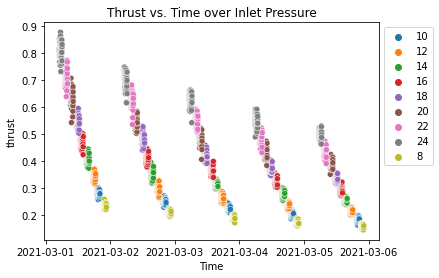

In [142]:
sns.scatterplot(x='Time',y='thrust',hue='Inlet Pressure',data=thruster_df)
plt.title("Thrust vs. Time over Inlet Pressure")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

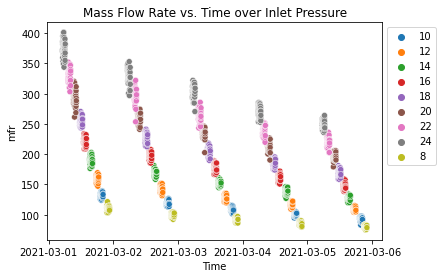

In [143]:
sns.scatterplot(x='Time',y='mfr',hue='Inlet Pressure',data=thruster_df)
plt.title("Mass Flow Rate vs. Time over Inlet Pressure")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

Mass flow rate and thruster rate look very much the same, and would expect that based on the nature of the data. If thrust increases, we would expect the flow rate to also increase. 

In [144]:
thruster_df['Inlet Pressure'] = thruster_df['Inlet Pressure'].apply(int)

<ipython-input-144-6488d1a28152>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:>

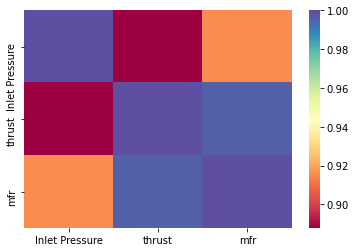

In [98]:
sns.heatmap(thruster_df.corr(),cmap='Spectral')

In [149]:
thruster_df.dtypes

Inlet Pressure             int64
Time              datetime64[ns]
thrust                   float64
mfr                      float64
dtype: object

In [152]:
detectTimeCorrelated(thruster_df.iloc[:,1:],'Time')

[]

In [153]:
thruster_df.corr()

,Inlet Pressure,thrust,mfr
Inlet Pressure,1.000000,0.887966,0.915652
thrust,0.887966,1.000000,0.996552
mfr,0.915652,0.996552,1.000000


There are no correlations with time, but the correlation between thrust and mfr are very high. Since these are going to be our only two features, and our targets, the model should do okay, but should be careful about overfitting when tuning the model. 

In [154]:
inlet8_df = mindf[mindf['Inlet Pressure'] == '8'].sort_values(by='Time')

In [155]:
inlet8_df.isna().sum()

Inlet Pressure       0
Time                 0
thrust            5494
mfr               5494
dtype: int64

In [156]:
firstrun_df = inlet8_df[inlet8_df['Time'] < '2021-03-02'].sort_values(by='Time')

In [157]:
# Ensuring there are no gaps in dataset
import datetime
deltas = firstrun_df['Time'].diff()[1:]
deltas[deltas > datetime.timedelta(minutes=1)]

Series([], Name: Time, dtype: timedelta64[ns])

In [158]:
firstrun_df.isna().sum()

Inlet Pressure     0
Time               0
thrust            84
mfr               84
dtype: int64

In [159]:
concat_df[(concat_df['Time'] < '2021-03-02')]['Time'].max()

Timestamp('2021-03-01 22:35:59.990000')

Nulls are found at the end of the dataset. When we resampled, it resamples each minute in the day, and since the data for one specific inlet pressure, nulls were filled in at the end. Therefore, we can drop these without any negative effect on the dataset 

In [160]:
firstrun_df.tail()

,Inlet Pressure,Time,thrust,mfr
46737,8,2021-03-01 23:55:00,NaN,NaN
46738,8,2021-03-01 23:56:00,NaN,NaN
46739,8,2021-03-01 23:57:00,NaN,NaN
46740,8,2021-03-01 23:58:00,NaN,NaN
46741,8,2021-03-01 23:59:00,NaN,NaN


In [161]:
firstrun_df = firstrun_df[~firstrun_df.isna().any(axis=1)]

In [163]:
x=firstrun_df['Time']

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=firstrun_df['thrust'], name="Thruster Output",
                    line_shape='linear'))

fig.update_traces(mode='lines')
fig.update_layout(legend=dict(y=0.5, traceorder='reversed', font_size=16))

fig.show()

In [164]:
alldat_df = concat_df.drop(['Inlet Pressure'],axis=1).resample('T',on='Time').mean().reset_index()

In [165]:
alldat_df.isna().sum()

Time         0
thrust    4081
mfr       4081
dtype: int64

In [166]:
x=alldat_df['Time']

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=alldat_df['thrust'], name="Thruster Output",
                    line_shape='linear'))

fig.update_traces(mode='lines')
fig.update_layout(legend=dict(y=0.5, traceorder='reversed', font_size=16))

fig.show()

As seen in above plot, the data is not continuous and no plausible way to interpolate the amount of missing values, after our efforts to join all the files together. Due to this and the sheer size of the raw data, we opted to just investigate our model on one dataset which we filtered out below.

In [170]:
#filter_df = concat_df[concat_df['Inlet Pressure'] == '8'].drop(['Inlet Pressure'],axis=1)
filter_df = concat_df[(concat_df['ton']==1) & (concat_df['Inlet Pressure'] == '8')].drop(['Inlet Pressure'],axis=1)
filter_df = filter_df[(filter_df['Time'] < '2021-03-02 7:00')]

In [171]:
filter_df_plot = filter_df.resample('S',on='Time').mean().reset_index()

In [172]:
x= filter_df_plot['Time']

fig = make_subplots(rows=2, cols=1) 

fig.add_trace(go.Scatter(x=x, y=filter_df_plot['thrust'], name="Thruster",
                    line_shape='linear'),
             row=1, col=1)

fig.add_trace(go.Scatter(x=x, y=filter_df_plot['mfr'], name="Mass Flow Rate",
                    line_shape='linear'),
             row=2,col=1)

fig.update_traces(mode='lines')
fig.update_layout(legend=dict(y=0.5, traceorder='reversed', font_size=12),
                  height=600, width=1000, title_text="Simulated Rocket Data")

fig.show()

After exploration of the data, it was determined that there was no way to join the data together based on the time of when it was took. Thus, to model this data we will have to look at the files individually. For sake of computational power and time, as well as length of the raw dataset (> 1B rows), we will investigate one of the simulated test runs at inlet pressure of 8, and resampled at the second scale, which is plotted above.

In [173]:
filter_df.drop(['Time','ton'],inplace=True,axis=1)

In [174]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(filter_df.values)

In [175]:
np.save("thruster_scaled_df",scaled_df)